In [1]:
# Importing required libraries and setting display options
import pandas as pd
import numpy as np
import altair as alt
from altair import datum, expr
import matplotlib.pyplot as plt
import datetime as dt
alt.renderers.enable('notebook')
pd.set_option('display.max_colwidth', -1)

In [2]:
# Reading in data
tchrs = pd.read_stata("../src/teacher_data.dta", convert_categoricals=False)
csos = pd.read_stata("../src/cso_data.dta", convert_categoricals=False)
dirs = pd.read_stata("../src/director_data.dta", convert_categoricals=False)

In [3]:
# Reporting interview counts by dataset
print(f"The Teacher dataset contains {tchrs.shape[0]} records\nThe CSO dataset contains {csos.shape[0]} records\nThe Director dataset contains {dirs.shape[0]} records")

The Teacher dataset contains 851 records
The CSO dataset contains 157 records
The Director dataset contains 257 records


The main questions we want to ask are documented in the [analysis plan](https://github.com/TSSlade/tusome-d4dm/blob/master/analysis_plan.md), which is an evolving document.

## Teacher Instrument

Here we begin exploring the data we obtained from interviewing the teachers.

In [4]:
# Counting teacher records
tchr_ct = tchrs.shape[0]

Our dataset contains interviews with {{tchr_ct}} teachers.

### Teachers visited previously by CSOs

The underlying assumption of most of the interview protocol is that the teacher has had a coaching interaction with a CSO. The first issue we should then address is the proportion of teachers who have received a visit from a CSO.

In [5]:
# Counting teachers never visited
never = 100 * ((tchr_ct - tchrs.vis_before.sum())/tchr_ct)

We see that {{np.round(never, decimals=2)}}% of teachers interviewed had never been previously visited by CSOs.

### Number of coaching visits in the last academic term

We have confirmed that the overwhelming majority of our teachers have been visited. We can have greater confidence in the responses they give us over the course of the interview if they have had a visit in the recent past. We therefore asked the teachers to tell us how many times they had been visited by their CSO in the preceding academic term (Term 2 of the Kenyan academic year, running from roughly May-July 2018).

In [6]:
# Generating CSO visit counts
tchrs.vis_before_freq = tchrs.vis_before_freq.replace({55: ">4x"})
viscount_df = pd.DataFrame(tchrs.vis_before_freq.value_counts(sort=False)).rename_axis("prevterm_vis").reset_index()
viscount_df["pct"] = np.round(100 * (viscount_df.vis_before_freq / tchrs.vis_before.sum()), decimals=2)
more_than_monthly = viscount_df[viscount_df.prevterm_vis.isin([4, ">4x"])].pct.sum()

csovisct_ch = alt.Chart(viscount_df, title="# of times CSO visited in preceding term").mark_bar().encode(
    alt.Y("prevterm_vis:O", title="CSO visits last term"),
    alt.X("vis_before_freq:Q", title="# Teachers"),
    tooltip="pct")

csovisct_ch.save("../img/csovisct_ch.svg", scale_factor=2.0)

![CSO Visits](../img/csovisct_ch.svg)

We see that roughly {{int(viscount_df[viscount_df.prevterm_vis==0].pct[0])}}% of the respondents, while they'd been visited by a CSO in the past, had not been visited in the preceding term. However, roughly {{int(viscount_df[viscount_df.prevterm_vis.isin([1, 2, 3])].pct.sum())}}% of the respondents were visited between once per term and once per month. Roughly {{int(more_than_monthly)}}% of the teachers were visited by their CSOs more frequently than monthly.

### CSOs' activities during last coaching visit

We are interested in knowing what CSOs are focusing on when they pay a visit to a school. Are they observing a lesson? Are they giving feedback to the teacher? Do they assess pupils' fluency rates? Do they take advantage of their presence at the school to meet with the head teacher (HT)? What kinds of things are they doing _besides_ these activities?

In [7]:
# Generating table of CSOs' activities during visits
visact_df = pd.DataFrame.from_dict({"activities": ["Assessed pupils",
                                                   "Talked to HT",
                                                   "Provided feedback on lesson",
                                                   "Had general talk",
                                                   "Other"],
                                    "tchrs_reporting": [tchrs[tchrs.vis_before != 0].vis_act_kids.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_ht.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_fdbk.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_gen.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_other.sum()]})
visact_df["pct"] = np.round(visact_df.tchrs_reporting.apply(lambda x: 100 * (x/(tchr_ct - never))), decimals=2)
visact_df

,activities,tchrs_reporting,pct
0,Assessed pupils,705,83.62
1,Talked to HT,533,63.22
2,Provided feedback on lesson,751,89.07
3,Had general talk,381,45.19
4,Other,133,15.77


In [8]:
# Generating the graph of CSOs' activities during the previous visit
csoprevvis_ch = alt.Chart(visact_df, title="CSO activities during previous visit").mark_bar().encode(
alt.Y("activities:O", 
      title="Activities named",
      sort = alt.EncodingSortField(field="tchrs_reporting", op="values", order="ascending")),
alt.X("pct:Q",
      title="% of teachers responding"),
tooltip = "tchrs_reporting")
csoprevvis_ch.save("../img/csoprevvis_ch.svg", scale_factor=2.0)

![CSOs' Activities](../img/csoprevvis_ch.svg)

Nearly {{int(np.ceil(visact_df.pct.max()))}}% of teachers report that when the CSO last visited, s/he provided feedback on a lesson. A fairly comparable proportion said that the CSO assessed pupils. Neither of these is surprising, as those activities are key features of a "reimbursable" or "valid" lesson observation. If anything, it is interesting that these numbers are not higher, given that we have excluded from our denominator those teachers who said they had never received a visit from the CSO.

Of note is the relatively low proportion of teachers reporting the CSO had spoken with the HT. While Tusome encourages CSOs to speak with HTs as part of the standard protocol for visiting a school, it is not explicitly considered as a factor for reimbursement of transportation costs for visiting that school.

That said, it is also possible that teachers may simply not be aware of activities taking place outside of their classroom. They and their classrooms would have been the objects of the lesson observation and fluency assessment; they may not have as much visibility into what happened before or after the CSO entered their classroom.

A little over {{int(np.floor(visact_df[visact_df.activities=="Other"].pct))}}% of teachers reported the CSO conducted an activity that was not listed in the questionnaire. Below we have sampled 20 of the things that they reported which were not captured in the questionnaire.

In [9]:
# Generating a list of the 'other' activities CSOs did when visiting
print(tchrs[tchrs.vis_act_other_det.notna() & (tchrs.vis_act_other_det != "")].vis_act_other_det.sample(20))

74     Checked on CBC infusion                                                                                                                                             
583    I see him move around the class as he looks at the charts on the wall                                                                                               
491    shortage of books                                                                                                                                                   
766    He sits back, watch as I teach, check pupils books, lesson plans, teaching notes and schemes of work.                                                               
635    To improve on resources in class.                                                                                                                                   
108    The CSO identified slow and non readers and guide me to suport them                                                                  

### CSOs using tablets or pen & paper during observation

The _Tangerine:Tutor_ app was developed with the intent and belief that CSOs would use it _while observing_ the lesson. However, Tusome staff report that not all CSOs find the tablet interface comfortable, and not all use it with ease. So we asked teachers to report whether CSOs use the tablets during the lesson observation, and also whether they use pen and paper.

Roughly {{int(np.round(100 * (tchrs.cso_usetab_yn.sum()/tchr_ct), decimals=2))}}% of teachers reported that the CSOs use tablets during lesson observation; roughly {{int(np.round(100 * (tchrs.cso_usepcl_yn.sum()/tchr_ct), decimals=2))}}% of teachers reported the CSOs use pen and paper during the lesson observation.

In [10]:
# Generating the table about usage of tablets and pencils
tabs_n_pencils = pd.crosstab(tchrs.cso_usetab_yn, tchrs.cso_usepcl_yn)
tabs_n_pencils = tabs_n_pencils.rename_axis("Uses tablet").rename_axis("Uses pen and paper", axis="columns")
tabs_n_pencils = tabs_n_pencils.rename({0: "No", 1: "Yes"}, axis="columns").rename({0: "No", 1: "Yes"}, axis="index")
tabs_n_pencils

Uses pen and paper,No,Yes
Uses tablet,,
No,3,17
Yes,74,672


We see that the overwhelming majority of CSOs are using both tablets _and_ pen-and-paper systems when observing the teachers' lesson. There have historically been some instruments/data that CSOs were tasked by TSC to complete that were not rendered in _Tangerine_ format on the tablets; as of midway through Term 3 of the 2018 academic year, those instruments (mostly for the TSC's TPAD \[Teacher Performance Appraisal and Development\] project) are now in _Tangerine_. While the use of pen and paper does not appear to have come at the expense of using the tablets - indeed, it appears to be complementary, as nearly all CSOs are using both - Tusome should nonetheless follow up on these reports of CSOs' usage of pen and paper to understand the roots of the practice.

### CSOs' usage of the tablets to assess pupils' performance

Tusome's coaching protocol requires CSOs to randomly select three children from the classroom at the end of the lesson to assess their reading fluency. The prompt the children are to read from is a laminated sheet of paper with a short passage printed on it; the CSOs are instructed to use the tablet to record the children's responses. The tablet is then able to calculate fluency rates and store those as data associated with that observation.

Approximately {{int(np.round(100 * (tchrs.cso_usetab_pup_yn.sum()/tchr_ct), decimals=2))}}% of the teachers reported that CSOs use the tablets to assess children's reading fluency.

### Teachers' experience of feedback, and CSOs' use of tablets during feedback

Tusome asked teachers whether the CSO gave feedback on the lesson last time s/he paid a visit, whether s/he used the tablet to do so, and whether the teacher was able to recall specific feedback the CSO provided.

In [11]:
# Generating table of CSO use of tablets for feedback
feedback = {"CSO gave feedback": tchrs.cso_gave_fdbk_yn.sum(),
            "CSO used a tablet for feedback": tchrs.cso_usetab_fdbk_yn.sum(),
            "Tchr remembers feedback": tchrs.cso_fdbk_remember.sum()}
fdbk_df = pd.DataFrame.from_dict(feedback, orient="index", columns=["ct"])
fdbk_df["pct"] = 100 * np.round(fdbk_df["ct"] / tchrs.shape[0], decimals=3)
fdbk_df = fdbk_df.rename_axis("event").reset_index()
fdbk_df

,event,ct,pct
0,CSO gave feedback,771.0,90.6
1,CSO used a tablet for feedback,692.0,81.3
2,Tchr remembers feedback,740.0,87.0


Below we have sampled 20 of the things that they reported which were not captured in the questionnaire.

In [12]:
# Sample of details regarding the details of feedback CSOs provided
print(tchrs[tchrs.cso_fdbk_det.notna() & (tchrs.cso_fdbk_det != "")].cso_fdbk_det.sample(20))

85     In English, he talked about sounds. There are some sounds that are challenging to me. So he helped me practice the sounds on his phone. He told me to download the sounds on my phone so that I can practice alot.                                     
788    I was new to the program, i had forgot to do prediction and he guided me during feedback session. I had also forgotten to give homework and he advised it is very important to give and mark homework                                                  
151    reinforced my understanding on the things i had done well during teaching,told me to follow the steps of teaching comprehension/ predictions, advised me on how to ensure that all pupils read to the expected fluency                                 
517    The CSO gave me feedback on the reading levels of my learners.                                                                                                                                                                      

The tablets come equipped with various aids that CSOs could use to help coach teachers. In addition to the contents of the auto-generated feedback, CSOs could use the _Papaya_ application to model pronunciation of letter sounds, the videos demonstrating effective lesson delivery, etc. Of the teachers reporting CSOs provided feedback of some kind, {{int(100* (tchrs.cso_fdbk_showtab_yn.sum() / tchrs.vis_act_fdbk.sum()))}}% indicated that the CSO showed them something directly on the tablet.

In [13]:
# Generating dataframe of feedback shown by CSOs to teachers
fdbk_shown_df = pd.DataFrame.from_dict({"resources": ["Tips from feedback screen",
                                                   "Pupils' reading fluency",
                                                   "Videos of lesson delivery",
                                                   "Letter sounds in Papaya",
                                                   "Other"],
                                    "tchrs_reporting":[
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_tips.sum(),
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_fluency.sum(),
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_video.sum(),
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_lsnd.sum(),
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_other.sum()]})
fdbk_shown_df["pct"] = np.round(
    fdbk_shown_df.tchrs_reporting.apply(
    lambda x: 100 * (x/visact_df[visact_df.activities=="Provided feedback on lesson"].tchrs_reporting)),
    decimals=2)
fdbk_shown_df

,resources,tchrs_reporting,pct
0,Tips from feedback screen,172,22.90
1,Pupils' reading fluency,272,36.22
2,Videos of lesson delivery,131,17.44
3,Letter sounds in Papaya,232,30.89
4,Other,57,7.59


In [14]:
# Generating chart of tablet-based resources shown to teachers
tabres_ch = alt.Chart(fdbk_shown_df, title="Tablet-based resources shown to Teachers by CSOs").mark_bar().encode(
alt.Y("resources:O", 
      title="Resources named",
      sort = alt.EncodingSortField(field="tchrs_reporting", op="values", order="ascending")),
alt.X("pct:Q",
      title="% of teachers responding"),
tooltip = "tchrs_reporting")
tabres_ch.save("../img/tabres_ch.svg", scale_factor=2.0)

![Tablet Resources Chart](../img/tabres_ch.svg)

Overall, fewer than 50% of teachers indicated that CSOs showed them something on the tablet as part of the feedback session. Where the CSO showed something to the teacher, it was most frequently pupils' reading fluency (at {{int(fdbk_shown_df[fdbk_shown_df.resources=="Pupils' reading fluency"].pct)}}%), with Papaya letter sounds the next most common (at {{int(fdbk_shown_df[fdbk_shown_df.resources=="Letter sounds in Papaya"].pct)}}%).

**N.B.**: <span style="color:red"> Update cell w literate programming re: which activity is in the lead. (Abstract one level further.)</span>

Below we have sampled 20 of the things that they reported which were not captured in the questionnaire.

In [15]:
# Printing sample of teachers' feedback re: things CSOs showed them on the tablet
print(tchrs[tchrs.cso_shw_other_det.notna() & (tchrs.cso_shw_other_det != "")].cso_shw_other_det.sample(20))

719    Downloaded the letter sounds on my smart phone                                                                                        
814    lesson duration                                                                                                                       
439    Video on teaching vocabulary                                                                                                          
220    The CSO recorded the lesson I taught and showed me how I was teaching                                                                 
549    pronounciation of a word in the dictionary                                                                                            
514    He showed me a video of a teacher teaching silent blending                                                                            
718    Downloaded the letter sounds on my smart phone                                                                                        
785   

### CSOs' use of feedback visit-over-visit

Tusome's theory of change stipulates that smaller, more frequent, and more targeted coaching interactions will shift teacher behavior more effectively than larger-scale, episodic training events that cover a broad range of topics. This is the reason Tusome invests so heavily in supporting CSOs to provide coaching support to teachers in the span between large-scale training events.

Teachers, like most people, will be more likely to alter their behavior if feedback is timely and consistent, and the teachers' response to it is monitored rather than assumed. In this survey, roughly {{int(100 * (tchrs[tchrs.vis_before != 0].cso_ref_prev_fdbk_yn.sum()/tchrs.vis_before.sum()))}}% of teachers indicated that when CSOs visited the school and observed the teacher, they follow up on feedback from earlier visits.

**T.D.**: <span style="color:red"> Update cells so definitions of variable `literate programming` inputs are visible.</span>

### Teachers self-reported improvement in response to coaching

Effectively measuring the quality of instruction or lesson delivery is a very, very difficult task. (**T.D.**: <span style="color:red"> Provide citations, examples of various approaches.</span>)

The current study was not able to directly assess the quality of teachers' lesson delivery, although Tusome is working on various other studies which attempt to do so. However, we asked teachers whether they felt the coaching received from CSOs had improved the quality of their teaching. We first posed the question in regard to the teaching of reading in Kiswahili and English, and then asked them whether the coaching had improved their teaching in other subjects as well.

In [16]:
# Generating dataframe of teacher's self-reported improvement due to coaching
better_tchr_df = pd.DataFrame.from_dict(
    {"subject": ["Kiswahili & English reading",
                  "Other subjects"],
     "tchrs_reporting": [tchrs[(tchrs.vis_act_fdbk != 0) &
                                (tchrs.vis_before != 0)].cso_fdbk_better_tus.sum(),
                          tchrs[(tchrs.vis_act_fdbk != 0) &
                                (tchrs.vis_before != 0)].cso_fdbk_better_nont.sum()]})
better_tchr_df["pct"] = np.round(
    better_tchr_df.tchrs_reporting.apply(
    lambda x: 100 * (x/tchrs[(tchrs.vis_act_fdbk !=0) & (tchrs.vis_before != 0)].vis_before.sum())),
    decimals=2)

bttr_tus_pct = better_tchr_df[better_tchr_df.subject=="Kiswahili & English reading"].pct
bttr_nont_pct = better_tchr_df[better_tchr_df.subject=="Other subjects"].pct
better_tchr_df

,subject,tchrs_reporting,pct
0,Kiswahili & English reading,748.0,99.73
1,Other subjects,722.0,96.27


Encouragingly, {{float(bttr_tus_pct)}}% and {{float(bttr_nont_pct)}}% - effectively all - teachers have indicated that the feedback they receive from CSOs has enabled them to be better teachers.

Below we have sampled 20 of the examples teachers gave for how their teaching has improved as a result of the feedback.

In [17]:
# Printing sample of things teachers say they do better
print(tchrs[tchrs.cso_fdbk_better_det.notna() & (tchrs.cso_fdbk_better_det != "")].cso_fdbk_better_det.sample(20))

509    advised me follow the script and always have a lesson plan                                                                                                                                               
130    I normally apply the aspect of I do we do you do in other learning areas                                                                                                                                 
248    showed me how to infuse the new curriculum to other learning areas, use of teaching materials line counters and charts                                                                                   
52     she told me by proper use of teachers lesson notes , the lesson flow is easy for the learners                                                                                                            
806    he told me to do proper lesson preparation, time management and pupils fluency levels                                                                        

### CSOs' discussion of pupil fluency

The ultimate goal of Tusome is to improve reading outcomes in grades 1-3. Whether the project has been successful is determined by the pupils' reading skills (with an emphasis on _oral reading fluency_, or ORF, and reading comprehension) as demonstrated by their performance on an early grade reading assessment (EGRA).

For a CSO's visit to be considered _complete_ or _valid_, one of the criteria is that it include an assessment of the reading skills of three randomly-selected pupils. These pupils are then provided a stimulus that contains a brief reading passage of ~50-100 words. As they read aloud from the stimulus, the CSO uses the _Tangerine_ application on the tablet to make note of any inaccurately read words. When the child has finished reading - or when 60 seconds elapses, whichever comes first - the assessment is complete. The child's fluency is then calculated using the formula

$$\frac{\text{# of correct words}}{\big(\frac{60 \ - \ \text{time remaining (s)}}{60}\big)} = \text{correct words per minute}$$

The _Tangerine_ software calculates the average fluency in _cwpm_ across all three pupils and reports it as part of the lesson feedback. The CSO is able - but not required - to bring up the pupils' fluency as part of their feedback session.

In [18]:
# Generating dataframe CSOs' discussions of fluency
fluency_disc_df = pd.DataFrame.from_dict({"response": [
    "CSO discusses fluency in feedback session",
    "Teacher finds discussion of fluency useful"],
    "tchrs_responding": [
        tchrs[tchrs.vis_before != 0].cso_fdbk_discfluency.sum(),
        tchrs[tchrs.vis_before != 0].cso_fdbk_flu_useful.sum()]})

fluency_disc_df["pct"] = np.round(100 * 
                        fluency_disc_df.tchrs_responding.apply(
                            lambda x: x / (tchrs.vis_before.sum())), decimals=2)

flu_cso_disc = fluency_disc_df[fluency_disc_df.response=="CSO discusses fluency in feedback session"].pct
flu_disc_use = fluency_disc_df[fluency_disc_df.response=="Teacher finds discussion of fluency useful"].pct
fluency_disc_df

,response,tchrs_responding,pct
0,CSO discusses fluency in feedback session,720.0,91.84
1,Teacher finds discussion of fluency useful,724.0,92.35


It appears the overwhelming majority of CSOs ({{float(flu_cso_disc)}}%) discuss the pupils' fluency with the teachers, and the teachers overwhelmingly ({{float(flu_disc_use)}}%) find it a useful discussion. But how do teachers make use of that insight?

Below we have sampled 20 of the examples teachers gave for what they do with knowledge of their pupils' fluency rates.

In [19]:
# Printing a sample of teachers' responses re: what they do with knowledge of fluency
print(tchrs[tchrs.cso_fdbk_flu_dowith.notna() & (tchrs.cso_fdbk_flu_dowith != "")].cso_fdbk_flu_dowith.sample(20))

611    For those learners who are slow I do remedial                                                                                                                            
40     Like there were times the learners were reading words with silent e wrongly e.g bike so I take time with the learners to perfect the same in class                       
517    I use this information to improve in the weak areas.                                                                                                                     
117    I use that information to improve on the reading levels when thay are low                                                                                                
406    I use the information to assist slow/non-readers and encourage them work in groups of mixed ability for peer support                                                     
269    am able to understand the fluency level of my learners so that i encourage those who are reading well and al

### Disruption caused by tablet use

Pupils are easily distracted by the presence of unfamiliar adults in the classroom. However, if the adult sits quietly and unobtrusively in the rear of the classroom, the children rapidly become acclimated to the visitor's presence and are able to focus on the lesson.

For many children in rural schools, however, tablet computers are an unfamiliar sight. Tusome was interested to know whether the CSOs' use of tablets to conduct the classroom observation or assess the pupils' fluency is perceived as disruptive.

In [20]:
# Generating dataframe re: pupils' distraction due to tablet use
tchr_dist_df = pd.DataFrame.from_dict({
    "case": [
        "CSO tablet use for observation",
        "CSO tablet use for feedback"],
    "distracting": [
        int(tchrs[tchrs.vis_before != 0].cso_tab_distract_yn.sum()),
        int(tchrs[tchrs.vis_before != 0].cso_tab_fdbk_distrac.sum())]})

tchr_dist_df["pct"] = 100 * np.round(tchr_dist_df.distracting.apply(
    lambda x: x / tchrs.vis_before.sum()),
             decimals=2)

distracting_tab_obs = float(tchr_dist_df[tchr_dist_df.case=="CSO tablet use for observation"].pct)
distracting_tab_fdbk = float(tchr_dist_df[tchr_dist_df.case=="CSO tablet use for feedback"].pct)

tchr_dist_df

,case,distracting,pct
0,CSO tablet use for observation,35,4.0
1,CSO tablet use for feedback,16,2.0


Reassuringly, very few teachers responded that they find it distracting when the CSO used a tablet during observation or during feedback ({{distracting_tab_obs}}% and {{distracting_tab_fdbk}}%, respectively). It is worth considering why they found the tablet use distracting; because the numbers are so low, the lists below present all responses rather than just a sample.

In [21]:
# Printing the reasons teachers think the tablets are distracting during observations
print(tchrs[(tchrs.cso_tab_distract_why != "") & tchrs.cso_tab_distract_why.notna()].cso_tab_distract_why)

1      Pupils get attention of the tablet                                                                                                                                                          
13     at times it is distracting when the CSO takes a photo using the tablet. This mostly affects the pupils. It was a challenge to me the first time she took the photos but now I am used to it.
26     some learners look at the CSO at the back of the class as he he uses tablet hence distracting their attention                                                                               
47     The curious one always keep on looking at the tablet instead of listening to me                                                                                                             
89     Some of the children sitting next to the children get distraccted and stop looking and the board.They are are also not comfortable because they are not used to it.                         
108    N/A s        

In [22]:
# Printing the reasons teachers feel the tablet use during feedback is distracting
print(tchrs[(tchrs.cso_fdbk_tab_diswhy != "") & tchrs.cso_fdbk_tab_diswhy.notna()].cso_fdbk_tab_diswhy)

35     it arouses curiosity therefore disrupt concentration of the learners                                                                                                                                                                                                         
50     I am distracted because i don't know what he will tell me                                                                                                                                                                                                                    
176    Because i am not aware what he is doing with the tablet but if both are looking at it, i will not find it distracting                                                                                                                                                        
206    My thinking is that the CSO is recording me and can be used in other places                                                                                       

While these results are encouraging, it may be that CSOs' tablet use is more distracting when it is the pupils themselves who are the object of the CSO's attention. We asked teachers whether they were present during the assessment of pupils' reading skills, and if so, whether it was their sense that pupils were distracted by the tablet use.

In [23]:
# Generating dataframe re: pupils' distraction due to tablet use during assessment
pupil_dist_df = pd.DataFrame.from_dict({
    "response": [
        "Teacher observed the assessment",
        "Pupils found the tablet distracting"],
    "tchrs_responding": [
        int(tchrs[tchrs.vis_before != 0].cso_pres_ass_tab.sum()),
        int(tchrs[tchrs.vis_before != 0].cso_pup_distract_ass.sum())]})

pupil_dist_df["numerator"] = [
    int(tchrs.vis_before.sum()),
    int(pupil_dist_df[pupil_dist_df.response=="Teacher observed the assessment"].tchrs_responding)]

pupil_dist_df["pct"] = 100 * np.round(pupil_dist_df.tchrs_responding / pupil_dist_df.numerator, 2)

tchrs_obsd_assmt = int(pupil_dist_df[pupil_dist_df.response=="Teacher observed the assessment"].pct)
pupils_distracted = int(pupil_dist_df[pupil_dist_df.response=="Pupils found the tablet distracting"].pct)

pupil_dist_df

,response,tchrs_responding,numerator,pct
0,Teacher observed the assessment,462,784,59.0
1,Pupils found the tablet distracting,99,462,21.0


Roughly {{tchrs_obsd_assmt}}% of the teachers said they had observed the CSO's assessment of the pupils' reading skills. Of those, {{pupils_distracted}}% thought the pupils found the tablet distracting. This may suggest a need for Tusome to provide additional training or orientation to CSOs on best practices in assessment administration.

Below we sample 20 of the reasons teachers provided for why they thought pupils found tablet use distracting during the assessment.

In [24]:
# Printing a sample of the reasons teachers think pupils find the tablet distracting
print(tchrs[(tchrs.cso_pup_dist_why != "") & tchrs.cso_pup_dist_why.notna()].cso_pup_dist_why.sample(20))

395    It was their first time to see the tablet and are not used to the CSO.                                                                                                                                                                                                                                                                                                                                                                                  
503    some pupils want to see what is on the tablet                                                                                                                                                                                                                                                                                                                                                                                                           
608    The pupils are distracted since they were reading directly from the tablet                       

### Teachers' ongoing assessment of pupil fluency

Teachers are fully capable of assessing their pupils' reading fluency without recourse to a tablet. However, RTI has experimented with an Android-based pupil performance tracking tool that might be of use to teachers. Therefore we were interested to understand the extent to which teachers are already assessing pupils' fluency, what tools they are using for the task, whether they have access to phones on which such a tool could be deployed, and whether they would want to use it if so.

In [25]:
# Calculating proportion of teachers who assess their pupils' fluency
tchrs_assessing = 100 * np.round(tchrs.tchr_ass_pup_flu_yn.sum() / tchrs.shape[0], decimals=2)

Roughly {{int(tchrs_assessing)}}% of teachers we spoke to indicated they assess their pupils' fluency. When asked to specify what tools they use for the task, they specified the following.

In [26]:
# Printing sample of tools teachers use to assess pupils' fluency
print(tchrs[(tchrs.tchr_ass_pup_flu_yn != 0) & (tchrs.tchr_ass_pup_tools != "") & tchrs.tchr_ass_pup_tools.notna()].tchr_ass_pup_tools.sample(20))

699    I write words or sentences on either the board or paper and choose individual learners at random to read.                                                                                                                    
267    a piece paper with writen text, Tusome textbook                                                                                                                                                                              
739    stories in the textbook                                                                                                                                                                                                      
570    I GIVE THEM THEIR BOOKS AND CALL ONE BY ONE TO READ THE SAME STORY TO FIND OUT WHO HAS PROBLEMS                                                                                                                              
50     I take a written paper with words and i time them as they read               

In [27]:
# Generating dataframe of teachers' access to phones and interest in a tool
tang_tool_df = pd.DataFrame.from_dict({
    "response": ["Teacher has a phone",
                 "Phone is an Android",
                 "Teacher would like a tool"],
    "tchrs_responding": [
        tchrs.tch_mob_phone.sum(),
        tchrs.tch_has_android.sum(),
        tchrs.tch_wants_assess.sum()]})

tang_tool_df["pct"] = 100 * np.round(tang_tool_df.tchrs_responding.apply(lambda x: x / tchrs.shape[0]), decimals=2)
tang_tool_df

,response,tchrs_responding,pct
0,Teacher has a phone,837.0,98.0
1,Phone is an Android,668.0,78.0
2,Teacher would like a tool,836.0,98.0


Nearly all teachers interviewed indicated they have access to a mobile phone; nearly 4 out of 5 teachers indicated their phone is an Android. Nearly all teachers - even those who don't have an Android - said they would like to have access to a tool that would provide them sample assessments they could do with their pupils.

## CSO Instrument

Here we begin exploring the data we obtained from interviewing the CSOs.

### Respondent Types

The CSO instrument was applied not only to CSOs, but also instructional coaches and (potentially) CSO-SNEs. We explore the number of respondents of each type in our dataset.

In [28]:
cso_desig_df = csos.designation
cso_desig_df.replace(
    [11, 12, 13, 88],
    ["CSO (Z)", "CSO-SNE (Z)", "Instructional Coach (Z)", "Other"],
    inplace=True)
# w.female.replace(['male', 'female'], [1, 0], inplace=True)
cso_desig_df.value_counts()

CSO (Z)    157
Name: designation, dtype: int64

### Length of experience using tablet-based Tangerine
_When did you first receive a tablet from Tusome or PRIMR?_

We want to convert the year/month CSOs provided into a number so we can work with it easily. We'll make the simplifying assumption that the tablet was received on the first day of the month they provided, and that this interview was conducted on the first day of the month. Neither of those are true, but the marginal days are unlikely to make a practical difference in a CSO's facility with the tool.

In [29]:
# Converting date tablet received into duration of tablet usage
now = dt.datetime(2018, 10, 1)
csos["tab_usage"] = pd.to_timedelta(now - pd.to_datetime({"year": csos.recd_tab_yr, "month": csos.recd_tab_month, "day": 1})).dt.days

We'll also want to convert the duration to months, since that will be easier to digest, and filter out any missing values.

In [30]:
# Generating dataframe of CSOs' tablet usage
tab_usage = pd.DataFrame(csos[csos.tab_usage.notna()].tab_usage / 30)

In [31]:
# Generating histogram of CSOs' tablet usage duration
csotabusage_ch = alt.Chart(tab_usage, title="Distribution of CSO tablet usage, months").mark_bar().encode(
    alt.X("tab_usage:Q", 
          bin=alt.BinParams(step=1), title="# Months has had a tablet"),
    alt.Y("count()", title="# of CSOs"))

csotabusage_ch.save("../img/csotabusage_ch.svg", scale_factor=2.0)

![Histogram of CSOs' tablet usage duration](../img/csotabusage_ch.svg)

We see that the majority of our CSOs have had their tablets for roughly {{int(tab_usage.tab_usage.mode()[0])}} months ({{np.round(tab_usage.tab_usage.mode()[0]/12, decimals=1)}} years). This is in keeping with the beginning of the Tusome program, and is as expected. CSOs who have had their tablets for longer are likely veterans of the PRIMR program (Tusome's predecessor); those who have had tablets for fewer months may have assumed their roles more recently. (CSO turnover due to retirement, promotion, maternity leave, etc. is an issue which Tusome is constantly needing to manage.)

### Proportion of CSOs reporting use of each application

_Which applications do you use frequently when supporting teachers? ...After recording unprompted responses, read the list of options and record responses._
  + Tangerine Tutor
  + Papaya
  + Tusome Books (in Adobe Acrobat)
  + Tusome Videos (in MX Player)

The CSOs' tablets come equipped with several tools meant to support their efforts as instructional coaches. These include the [_Tangerine:Tutor_](http://www.tangerinecentral.org/tutor/) application, the [_Papaya_](http://schoolsnetkenya.com/tusome-early-literacy-programme-sounds-application/) application, PDF versions of Tusome's instructional materials (pupil's books and teacher's guides), and videos that model effective instructional delivery.

We are interested in which of those tools CSOs use, and how frequently. We will provide an analysis of their unprompted free-response answers to the question above. For the moment, we note the tools they said they use when we explicitly prompted them with the list of tools available.

In [32]:
# Generating a dataframe of CSOs' application usage
app_users = {"tutor": csos.freqapps_tt_promp.sum(),
         "papaya": csos.freqapps_papaya_promp.sum(),
         "books": csos.freqapps_bks_promp.sum(),
         "videos": csos.freqapps_vids_promp.sum()}
app_usage = pd.DataFrame.from_dict(app_users, orient="index", columns=["ct"])
app_usage["pct"] = 100 * np.round(app_usage["ct"] / csos.shape[0], decimals=3)
app_usage = app_usage.rename_axis("app").reset_index()

In [33]:
# Generating bar chart of CSOs' tablet usage
tooluse_ch = alt.Chart(app_usage, title="Proportion of CSOs reporting tool usage").mark_bar().encode(
    alt.Y("app:O",
          title="Application",
          sort = alt.EncodingSortField(field="pct", op="values", order="ascending"),
          ),
    alt.X("pct:Q", title="% of CSOs reporting usage"),
    tooltip="pct")

tooluse_ch.save("../img/tooluse_ch.svg", scale_factor=2.0)

![Chart of CSOs reported tool usage patterns](../img/tooluse_ch.svg)

The overwhelming majority of the CSOs report using all of the applications. That said, the videos and books are used less frequently.

### Proportion of CSOs who refer to Tangerine to provide post-observation feedback

_Do you refer to Tangerine when giving teachers feedback after observing a lesson?_

The _Tangerine:Tutor_ application analyzes the pattern of the CSO's responses to the observation items and surfaces actionable feedback that could be shared with the teacher to improve her or his instruction. While the auto-generated feedback is intended as a tool to help CSOs give more effective guidance to teachers, it can be quite extensive and is not prioritized. We were interested to know whether the CSOs make reference to the application's auto-generated feedback when they hold their post-observation debriefing session with the teacher.

In [34]:
# Calculating pct of CSOs wo give feedback after a lesson
cso_ls_fdbk_sc = 100 * np.round(csos.ref_tang_fdbk.sum() / csos.shape[0], decimals=3)

Again, the overwhelming majority of CSOs - {{cso_ls_fdbk_sc}}% - report using the auto-generated feedback when holding their debrief session with the teacher. We will separately provide an analysis of their open-ended answers regarding _what_ they refer to and what they find most useful.

### Proportion of CSOs who use Tangerine to plan their work

_Do you refer to Tangerine to help you plan your work when you are **not** either observing a teacher or giving the teacher feedback?_

Version 3 of the _Tangerine:Tutor_ application features a screen which allows a CSO to see schools they have visited and which they have not. We were interested to know whether the CSOs are leveraging this feature—or others, such as the pupils' fluency rates, which are reported in the feedback—to make decisions about which schools to visit in the future.

In [35]:
# Generating proportion of CSOs who use Tangerine to plan their work
cso_tangplanners = 100 * np.round(csos.refer_tang_nonobs.sum() / csos.shape[0], decimals=3)

Fewer than two-thirds of CSOs ({{cso_tangplanners}}%) refer to Tangerine to plan their work. A sampling of the reasons they gave for not using it is provided below:

In [36]:
# Generating sample of reasons CSOs don't use Tangerine to plan their work
csos[csos.tang_nonobs_nowhynot.notnull() & (csos.tang_nonobs_nowhynot != "")].tang_nonobs_nowhynot.sample(10)

93     I normally use it for the observation and writing reports                                                                                           
26     Tangerine is only meant for school.                                                                                                                 
47     I don't think I have any reason because I have my own program. I only use it when I am going to school. We normally prepare our own program of work.
31     She uses the personal schools information record to plan which school and teachers to support                                                       
58     There is no form or provision to enter work plans or any other planned                                                                              
62     I am still learning how to use the various features of the tangerine. With time, I will be able to use it more efficiently.                         
152    The fear of GPS readings                                 

This result surfaces a few issues Tusome might consider addressing next time CSOs receive a refresher training on Tangerine's use.
  1. A lack of awareness of how the information provided by the tablet (schools visited and not visited) could be operationalized
  1. A fear that they would be accused of falsifying observation data, rooted specifically in a misunderstanding of the application's GPS-capture functionality
  1. A mental compartmentalization of Tangerine as being a Tusome-specific tool, not for use in broader contexts

Other reasons given suggest that the need which Tangerine might fill is already being addressed separately.
  1. The CSO keeps a personal record (outside of the tablet) in which they track school visitation
  1. The CSO has prepared a work schedule, and uses that as their guide until the month's activities have concluded.

### Frequency with which CSOs refer to the application

\[If the CSO refers to the Tangerine for planning purposes\], _how often do you reference the data?_



In [37]:
# Generating dataframe of how frequently CSOs refer to the Tangerine application
tchk_freq = csos[csos.freq_refer_tang_plan.notna()].freq_refer_tang_plan.sort_values().value_counts(sort=False).to_frame(name="ct")
tchk_freq = tchk_freq.rename_axis("frequency").reset_index()
tchk_freq["frequency"] = tchk_freq["frequency"].replace({
    1: "Daily", 
    2: "Weekly",
    3: "Monthly",
    4: "Termly",
    88: "Other"})
tchk_freq["sort_order"] = tchk_freq.index
tchk_freq

,frequency,ct,sort_order
0,Daily,24,0
1,Weekly,48,1
2,Monthly,19,2
3,Termly,4,3
4,Other,1,4


It appears that among the CSOs who check the application, it is most common to check it at least {{tchk_freq.frequency.loc[tchk_freq.ct == tchk_freq.ct.max()].str.lower()[1]}}.

In [38]:
# Generating chart of Tangerine App checking behavior
tappchk_ch = alt.Chart(tchk_freq, title="Tangerine app checking behavior").mark_bar().encode(
    alt.X("ct:Q"),
    alt.Y("frequency:O", sort = alt.EncodingSortField(field="sort_order:Q", op="values", order="ascending")),
    color = "frequency")

tappchk_ch.save("../img/tappchk_ct.svg", scale_factor=2.0)

![Chart of CSOs' Tangerine app-checking behavior](../img/tappchk_ct.svg)

### CSO reference to the Tangerine Dashboard

_In the last term, how often did you look at the Tangerine Dashboard?_

The data that is generated by the CSOs' lesson observations is uploaded to the cloud and reported on the [Tangerine Dashboard](http://tools.tusome.tangerinecentral.org/_csv/report/group-national_tablet_program/00b0a09a-2a9f-baca-2acb-c6264d4247cb,c835fc38-de99-d064-59d3-e772ccefcf7d/2018/1/ep8yqMKT.html#tutor). This Dashboard is reviewed by senior management within the Ministry of Education: the Principal Secretary, his Directors, and their deputies. It is also sent to the Directors of MOE and TSC at the County level. As these latter personnel oversee the CSOs, the Dashboard may have an effect ...

In [39]:
# Generating a dataframe of CSOs' Tangerine Dashboard viewing patterns
cso_db_chk = pd.DataFrame(csos[["refer_tang_nonobs", "db_chk_prevterm_freq", "cdir_comm_reres"]])
cso_db_chk.rename(columns={"refer_tang_nonobs":"tapp_planning", "db_chk_prevterm_freq": "db_check_ct"}, inplace=True)
grp_cso_db_chk = cso_db_chk.groupby(["tapp_planning", "db_check_ct", "cdir_comm_reres"])["db_check_ct"].count().to_frame()
grp_cso_db_chk = grp_cso_db_chk.rename(columns={"db_check_ct": "respondent_ct"}).reset_index()
grp_cso_db_chk

,tapp_planning,db_check_ct,cdir_comm_reres,respondent_ct
0,0.0,0.0,0.0,15
1,0.0,0.0,1.0,16
2,0.0,0.0,2.0,2
3,0.0,1.0,0.0,7
4,0.0,1.0,1.0,10
5,0.0,2.0,0.0,2
6,0.0,2.0,1.0,3
7,0.0,3.0,0.0,1
8,0.0,3.0,1.0,1
9,0.0,4.0,1.0,1


In [40]:
# # Generating a bar chart of DB-checking behavior faceted by whether the CSO checks the Tangerine app for planning
# base = alt.Chart(grp_cso_db_chk, title="CSOs' Dashboard checking behavior").mark_bar().encode(
#     alt.Y("respondent_ct:Q"),
#     alt.X("db_check_ct:O"),
#     color="tapp_planning:O")

# for check_yn in [0, 1]:
#     csodbchk_ch |= base.transform_filter(datum.tapp_planning == check_yn)
    
# csodbchk_ch.save("../img/csodbchk_ch2.svg", scale_factor=2.0)
# # csodbchk_ch

!["Graph of CSOs' DB-checking behavior"](../img/csodbchk_ch.png)

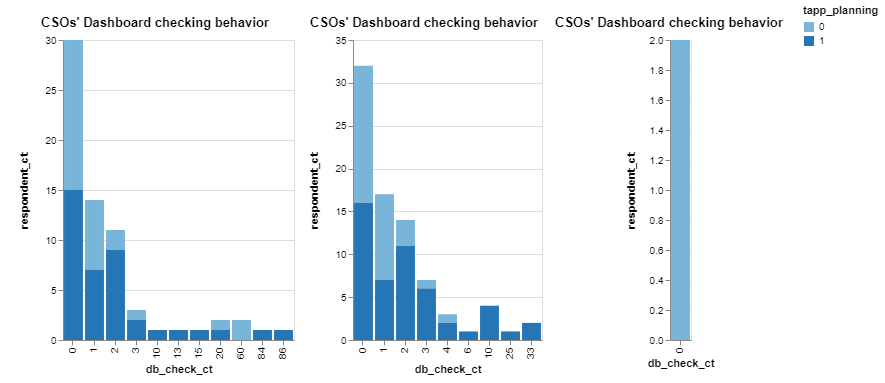

In [41]:
base2 = alt.Chart(grp_cso_db_chk, title="CSOs' Dashboard checking behavior").mark_bar().encode(
    alt.Y("respondent_ct:Q"),
    alt.X("db_check_ct:O"),
    color="tapp_planning:O")

# csodbchk_ch = alt.hconcat()
# for dc in grp_cso_db_chk["cdir_comm_reres"].unique():
# for dc in [0., 1., 2.]:
#     colch &= base2.transform_filter(datum.cdir_comm_reres == dc),
# for check_yn in [1, 0]:
#     row |= base2.transform_filter(datum.tapp_planning == check_yn)

#create a list of subplots
subplts = []
for dc in grp_cso_db_chk['cdir_comm_reres'].unique():
    subplts.append(base2.transform_filter(datum.cdir_comm_reres == dc))

def facet_wrap(subplts, plots_per_row):
    rows = [subplts[i:i+plots_per_row] for i in range(0, len(subplts), plots_per_row)]
    compound_chart = alt.hconcat()
    for r in rows:
        rowplot = alt.vconcat() #start a new row
        for item in r:
            rowplot |= item #add suplot to current row as a new column
        compound_chart &= rowplot # add the entire row of plots as a new row
    return compound_chart

compound_chart = facet_wrap(subplts, plots_per_row=3)    
compound_chart

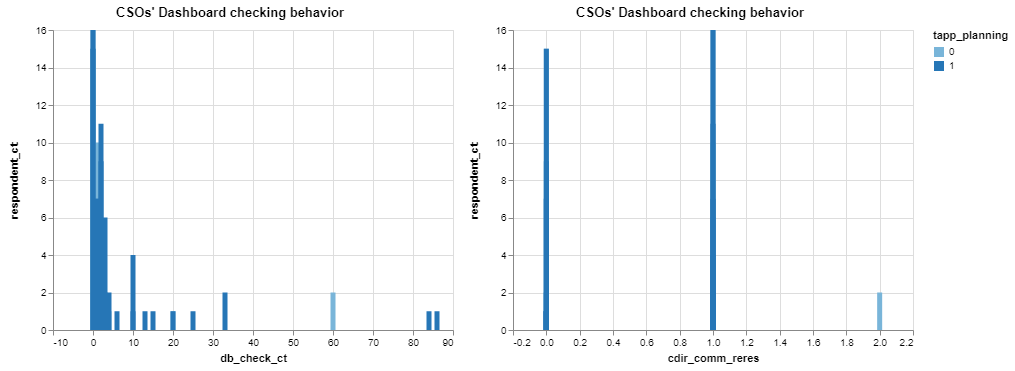

In [42]:
base3 = alt.Chart(grp_cso_db_chk, title="CSOs' Dashboard checking behavior").mark_bar().encode(
    alt.X(alt.repeat("column"), type = 'quantitative'),
    alt.Y("respondent_ct:Q"),
    color="tapp_planning:O").repeat(
#     row=['db_check_ct', 'cdir_comm_reres'],
    column=['db_check_ct', 'cdir_comm_reres']
)

# csodbchk_ch = alt.hconcat()
# grid = alt.vconcat(data=grp_cso_db_chk)
# for y_encoding in ["tapp_planning:O", ""]:
#     row = alt.hconcat()
#     for dirchk in ["Yes", "No", 2]
#         row |= base.encode(y = "respondent_ct:Q"),
#     alt.X("db_check_ct:O"),)
# csodbchk_ch |= base.transform_filter(datum.tapp_planning == check_yn)
    
base3

### Proportion of CSOs whose Directors communicate re Dashboard data


In [43]:
# Generating chart of directors' communication re Dashboard
dircomms_df = pd.DataFrame.from_dict({
    "dir_comms": ["yes", "no", "unknown"],
    "ct": [
        csos[csos.cdir_comm_reres==1].cdir_comm_reres.count(),
        csos[csos.cdir_comm_reres==0].cdir_comm_reres.count(),
        csos[csos.cdir_comm_reres==2].cdir_comm_reres.count(),
    ]})
                                      
dircomms_df["pct"] = 100 * np.round(dircomms_df.ct / csos.shape[0], decimals=1)

In [44]:
dircomms_ch = alt.Chart(dircomms_df).mark_bar().encode(
    alt.Y("pct:Q"),
    alt.X("dir_comms:O", sort = alt.EncodingSortField(field="sort_order:Q", op="values", order="ascending")))

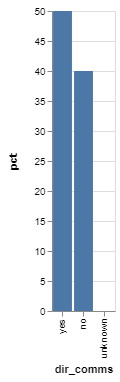

In [45]:
dircomms_ch

In [46]:
relx_changes_df = pd.DataFrame.from_dict(
    {"role": ["teacher",
              "headteacher",
              "TSC Subcounty Dir (SC)",
              "TSC County Dir (C)",
              "MOE Subcounty Dir (SC)",
              "MOE County Dir (C)"],
     "got_better_ct": [csos.relx_better_tchr.sum(),
                    csos.relx_better_ht.sum(),
                    csos.relx_better_tscscd.sum(),
                    csos.relx_better_tsccd.sum(),
                    csos.relx_better_moescd.sum(),
                    csos.relx_better_moecd.sum(),],
     "got_worse_ct": [csos.relx_worse_tchr.sum(),
                   csos.relx_worse_ht.sum(),
                   csos.relx_worse_tscscd.sum(),
                   csos.relx_worse_tsccd.sum(),
                   csos.relx_worse_moescd.sum(),
                   csos.relx_worse_moecd.sum(),],
     "no_change_ct": [csos.relx_nochg_tchr.sum(),
                   csos.relx_nochg_ht.sum(),
                   csos.relx_nochg_tscscd.sum(),
                   csos.relx_nochg_tsccd.sum(),
                   csos.relx_nochg_moescd.sum(),
                   csos.relx_nochg_moecd.sum(),]})
relx_changes_df["got_better_pct"] = 100 * np.round(relx_changes_df.got_better_ct / csos.shape[0], decimals=2)
relx_changes_df["got_worse_pct"] = 100 * np.round(relx_changes_df.got_worse_ct / csos.shape[0], decimals=2)
relx_changes_df["no_change_pct"] = 100 * np.round(relx_changes_df.no_change_ct / csos.shape[0], decimals=2)

relx_changes_df

,role,got_better_ct,got_worse_ct,no_change_ct,got_better_pct,got_worse_pct,no_change_pct
0,teacher,156,3,0,99.0,2.0,0.0
1,headteacher,149,3,6,95.0,2.0,4.0
2,TSC Subcounty Dir (SC),102,9,32,65.0,6.0,20.0
3,TSC County Dir (C),102,8,38,65.0,5.0,24.0
4,MOE Subcounty Dir (SC),80,13,50,51.0,8.0,32.0
5,MOE County Dir (C),75,11,58,48.0,7.0,37.0


In [47]:
# Generating a stacked bar chart of the relationship changes



In [48]:
# Calculating the proportion of CSOs who say their Director has announced serious consequences
consequence_sc = 100 * np.round(csos.cdir_conseq_yn.sum()/csos.shape[0], decimals=2)
consequence_sc

35.0

In [49]:
print(csos[(csos.cdir_conseq_yn==1) & (csos.cdir_conseq_det.notna()) & (csos.cdir_conseq_det != "")].cdir_conseq_det.sample(20))

18     the CSO was given a warning but gave room for them to upload the data if there was any                                                                           
123    Most of us were told to put more doing schoool support visit.                                                                                                    
42     A warning that is the employer is watching and we wiil take stern action                                                                                         
150    he promised to visit the concerned CSO especially those doing bad to assertain the reason behind poor achievementa among pupils.                                 
121    The director told us we must improve because the data in the dashboard was not impressive.                                                                       
59     I improved on my classroom observation visits and uploaded at the right time                                                                        

In [50]:
# This is a really scary response!!
csos.cdir_conseq_det[98]

'The CDE called a meeting to discuss the dashboard. We were informed that the dashboard gives the national and the county outlook. Thi sgives the impression to the donors. Once the support is not seen as necessary, then it affects funding to schools not just on CSOs facilitation, but also the books and everything about learning. so we have to be careful.'

## Director Data

### Roles and designations of respondents

In [51]:
# Tabulating `designation`
# resp_desig_df = dirs.designation
# resp_desig_df.replace(
dirs.designation.replace(
    [21, 22, 23, 31, 32, 33, 34, 35, 36, 37, 38, 39, 88],
    ["MOE Subcounty Dir [SC]", "TSC Subcounty Dir [SC]",
     "Quality Assurance and Standards Officer (QASO) [SC]", "MOE County Dir [C]",
     "TSC County Dir [C]", "County QASO [C]", "Subcounty HR Officer [SC]",
     "Regional Coord of Edu [R]", "County Project Coord [C]",
     "Deputy County Dir [C]", "Chief Edu Officer [SC]", "Asst Dir QAS [N]",
     "Other"],
    inplace=True)
resp_desig_df = dirs.designation
resp_desig_df = resp_desig_df.value_counts().rename_axis("designation").reset_index(name="ct")
resp_desig_df["pct"] = 100 * np.round(resp_desig_df.ct / dirs.shape[0], decimals=2)

sites = ["national", "regional", "county", "subcounty", "zone"]
conditions = [resp_desig_df.designation.str.contains("\[N\]"),
             resp_desig_df.designation.str.contains("\[R\]"),
             resp_desig_df.designation.str.contains("\[C\]"),
             resp_desig_df.designation.str.contains("\[SC\]"),
             resp_desig_df.designation.str.contains("\[Z\]")]

resp_desig_df["location"] = np.select(conditions, sites, default="other")
resp_desig_df

,designation,ct,pct,location
0,MOE Subcounty Dir [SC],78,30.0,subcounty
1,Quality Assurance and Standards Officer (QASO) [SC],66,26.0,subcounty
2,TSC Subcounty Dir [SC],48,19.0,subcounty
3,TSC County Dir [C],20,8.0,county
4,MOE County Dir [C],20,8.0,county
5,County QASO [C],5,2.0,county
6,Deputy County Dir [C],3,1.0,county
7,Other,3,1.0,other
8,Chief Edu Officer [SC],3,1.0,subcounty
9,Subcounty HR Officer [SC],3,1.0,subcounty


In [52]:
dirs.designation.unique()

array(['MOE Subcounty Dir [SC]',
       'Quality Assurance and Standards Officer (QASO) [SC]',
       'TSC Subcounty Dir [SC]', 'TSC County Dir [C]', nan,
       'County QASO [C]', 'Deputy County Dir [C]',
       'County Project Coord [C]', 'MOE County Dir [C]', 'Other',
       'Subcounty HR Officer [SC]', 'Chief Edu Officer [SC]',
       'Asst Dir QAS [N]', 'Regional Coord of Edu [R]'], dtype=object)

In [53]:
# sorted(dirs[(dirs.desig_other_det.notna()) & (dirs.desig_other_det != "N/A")].desig_other_det)
# dirs[dirs.designation==88].desig_other_det
dirs.columns

Index(['county', 'subcounty', 'designation', 'desig_other_det', 'intro_db_yr',
       'intro_db_month', 'src_pre_db_decaid', 'get_link_yn', 'get_link_freq',
       'get_link_modality', 'db_lnk_chk_sday', 'db_lnk_chk_sweek',
       'db_lnk_chk_smonth', 'db_lnk_chk_dont', 'db_lnk_chk_dont_why',
       'db_lnk_chk_na', 'db_unp_devices', 'db_prmp_dev_phone',
       'db_prmp_dev_tab', 'db_prmp_dev_laptop', 'db_prmp_dev_desktop',
       'db_prmp_dev_colleague', 'db_prmp_dev_other', 'db_prmp_dev_other_det',
       'db_dev_access_na', 'db_lnk_frm_other_yn', 'db_lnk_frm_other_det',
       'no_lnk_wnt_yn', 'no_lnk_wnt_freq', 'del_mech_unprompted',
       'del_mech_prp_sms', 'del_mech_prp_wa', 'del_mech_prp_email',
       'del_mech_prp_app', 'del_mech_prp_other', 'del_mech_prp_det',
       'db_sect_consulted', 'db_chk_freq', 'mgmt_dec_from_db',
       'db_info_wnt_yn', 'db_info_wnt_det', 'diff_mgmt_nodata_yn',
       'diff_mgmt_nodata_det', 'db_rev_feat_det', 'filename', 'duplicatecheck',
       

### Duration of experience with the Tangerine Dashboard

In [54]:
# Convert `intro_db_yr`, `intro_db_month` into months as we did with CSOs
now = dt.datetime(2018, 10, 1)
dirs["db_usage"] = pd.to_timedelta(now - pd.to_datetime({"year": dirs.intro_db_yr, "month": dirs.intro_db_month, "day": 1})).dt.days
dirs.db_usage = dirs.db_usage / 30

In [55]:
# Generate a histogram from the duration of time they've known about the Dashboard; facet by `designation`
# db_usage_df = pd.DataFrame(dirs[dirs.db_usage.notna()].db_usage / 30)
db_usage_df = dirs[["db_usage", "designation"]]
dirdbusage_ch = alt.Chart(db_usage_df, title="Distribution of Dirs' Dashboard usage, months").mark_bar().encode(
    alt.X("db_usage:Q", 
          bin=alt.BinParams(step=1), title="# Months has known about Dashboard"),
    alt.Y("count()", title="# of Respondents"))
#     color="designation:N")

dirdbusage_ch.save("../img/dirdbusage_ch.svg", scale_factor=2.0)

**T.D.**: <span style="color:red"> Facet the graph by respondent type.</span>

![Histogram of Dirs' Dashboard Usage](../img/dirdbusage_ch.svg)

### Respondents' decision-making supports pre-Tangerine Dashboard

In [56]:
# Print a sample of `src_pre_db_decaid`
for rtype in dirs[dirs.designation.notna()].designation.unique():
    i = 20
    j = dirs[(dirs.designation==rtype) & (dirs.src_pre_db_decaid!="") & (dirs.src_pre_db_decaid.notna())].shape[0]
    while i > j:
        i -= 1
    print("*"*20, "\n" + "*"*20,"\n" +
          f"{i} statements sampled from the {j} {rtype} responses " +
          "regarding how they made decisions before the Dashboard was " +
          "available\n" +
          "*"*20 + "\n" +
          "*"*20, "\n")
    print(dirs[dirs.designation==rtype].src_pre_db_decaid.sample(i))
    print("\n")


******************** 
******************** 
20 statements sampled from the 76 MOE Subcounty Dir [SC] responses regarding how they made decisions before the Dashboard was available
********************
******************** 

96     I was doing a follow up on what was agreed upon and enquired from the officers. I was also refering to other records .                                                                                                                                                                                                                                                                                          
53     I was not posted as a director by then and even this Sub County was not in existence                                                                                                                                                                                                                                                                                     

In [57]:
# Tabulate the responses to `diff_mgmt_nodata_yn` and sample the responses to `diff_mgmt_nodata_det`.
# mgmt_diff_df = dirs[["designation","diff_mgmt_nodata_yn"]].groupby(["designation", "diff_mgmt_nodata_yn"])
mgmt_diff_df = dirs.groupby(["designation", "diff_mgmt_nodata_yn"])["diff_mgmt_nodata_yn"].count().to_frame()
mgmt_diff_df = mgmt_diff_df.rename(columns={"diff_mgmt_nodata_yn": "has_difficulty"}).reset_index()
mgmt_diff_df = mgmt_diff_df.pivot(index="designation", columns="diff_mgmt_nodata_yn", values="has_difficulty")
mgmt_diff_df = mgmt_diff_df.rename(columns={0: "no", 1: "yes"}).fillna(0)
mgmt_diff_df["pct"] = 100 * np.round(mgmt_diff_df.yes / (mgmt_diff_df.no + mgmt_diff_df.yes), decimals = 2)
sites = ["national", "regional", "county", "subcounty", "zone"]
conditions = [mgmt_diff_df.index.str.contains("\[N\]"),
              mgmt_diff_df.index.str.contains("\[R\]"),
              mgmt_diff_df.index.str.contains("\[C\]"),
              mgmt_diff_df.index.str.contains("\[SC\]"),
              mgmt_diff_df.index.str.contains("\[Z\]")]

mgmt_diff_df["location"] = np.select(conditions, sites, default="other")
mgmt_diff_df.sort_values("location")

diff_mgmt_nodata_yn,no,yes,pct,location
designation,,,,
County Project Coord [C],2.0,0.0,0.0,county
County QASO [C],3.0,2.0,40.0,county
Deputy County Dir [C],2.0,1.0,33.0,county
MOE County Dir [C],10.0,10.0,50.0,county
TSC County Dir [C],8.0,12.0,60.0,county
Asst Dir QAS [N],2.0,0.0,0.0,national
Other,1.0,2.0,67.0,other
Regional Coord of Edu [R],0.0,1.0,100.0,regional
Chief Edu Officer [SC],1.0,2.0,67.0,subcounty


In [58]:
# Print a sample of `diff_mgmt_nodata_det`
for rtype in dirs[dirs.designation.notna()].designation.unique():
    i = 20
    j = dirs[(dirs.designation==rtype) & (dirs.diff_mgmt_nodata_det!="") & (dirs.diff_mgmt_nodata_det.notna())].shape[0]
    while i > j:
        i -= 1
    print("*"*20, "\n" + "*"*20,"\n" +
          f"{i} statements sampled from the {j} {rtype} responses " +
          "regarding specific examples of daily decisions they have " +
          "difficulty taking because of a lack of relevant, actionable data\n" +
          "*"*20 + "\n" +
          "*"*20, "\n")
    print(dirs[dirs.designation==rtype].diff_mgmt_nodata_det.sample(i))
    print("\n")

******************** 
******************** 
20 statements sampled from the 37 MOE Subcounty Dir [SC] responses regarding specific examples of daily decisions they have difficulty taking because of a lack of relevant, actionable data
********************
******************** 

244                                                                                                                                                                                                                                  
172                                                                                                                                                                                                                                  
155    Though it may not come to me directly, enrolment and teacher presence per day.                                                                                                                                                
55     i dobt have a tablet, it c

### Respondents' receipt of the Tangerine Dashboard link

In [59]:
# Report % of respondents who receive the dashboard link (`get_link_yn`)
lnk_receipt = 100 * np.round(dirs.get_link_yn.count()/dirs.shape[0], decimals=2)
lnk_receipt

97.0

In [99]:
# Summarize the frequency with which it is received (`get_link_freq`)
lnk_receipt_freq_df = dirs.get_link_freq.value_counts().rename_axis("frequency").reset_index(name="ct")
lnk_receipt_freq_df.frequency = lnk_receipt_freq_df.frequency.map({
    0: "Does not receive",
    1: "At least daily",
    2: "At least weekly",
    3: "At least monthly",
    4: "At least termly",
    5: "At least yearly",
    6: "Infrequently or unknown"})
lnk_receipt_freq_df["pct"] = 100 * np.round(lnk_receipt_freq_df.ct / dirs.shape[0], decimals=2)
lnk_receipt_freq_df

,frequency,ct,pct
0,At least monthly,26,10.0
1,At least termly,24,9.0
2,Infrequently or unknown,17,7.0
3,At least yearly,5,2.0


In [100]:
# Summarize the modality (`get_link_modality`)


**T.D.**: <span style="color:red"> Clean the Director modality-of-receipt data and analyze here.</span>

In [62]:
# Consider faceting the above by `designation`

In [113]:
# Generate a stacked bar chart of the prompted dashboard receipt device frequencies:
# ```
# db_prmp_dev_phone
# db_prmp_dev_laptop
# db_prmp_dev_desktop
# db_prmp_dev_colleague
# db_prmp_dev_other
# ```
pref_mod_df = dirs[["designation","db_prmp_dev_phone","db_prmp_dev_laptop",
                    "db_prmp_dev_desktop", "db_prmp_dev_colleague",
                    "db_prmp_dev_other"]]
pref_mod_df = pref_mod_df.groupby("designation").sum()
pref_mod_df.rename(
    columns = {"db_prmp_dev_phone": "phone",
               "db_prmp_dev_laptop": "laptop",
               "db_prmp_dev_desktop": "desktop",
               "db_prmp_dev_colleague": "colleague",
               "db_prmp_dev_other": "other"}, inplace=True)
pref_mod_df.loc["Total"] = pref_mod_df.sum(axis=0)
pref_mod_df

,phone,laptop,desktop,colleague,other
designation,,,,,
Asst Dir QAS [N],0,2,0,1,0
Chief Edu Officer [SC],1,0,1,0,0
County Project Coord [C],2,0,0,0,0
County QASO [C],1,1,1,0,0
Deputy County Dir [C],1,0,0,0,0
MOE County Dir [C],8,4,4,3,4
MOE Subcounty Dir [SC],33,9,20,9,1
Other,2,1,2,0,0
Quality Assurance and Standards Officer (QASO) [SC],19,10,5,5,3


In [114]:
# Sample responses to `db_prmp_dev_other_det`.
dirs[(dirs.db_prmp_dev_other_det.notna()) & (dirs.db_prmp_dev_other_det != "")].db_prmp_dev_other_det.sample(20)

62     Printed paper                                                                                                     
160    I can get updates throgh these divices                                                                            
131    I can receive through the personal phone,office emails or personal email address.                                 
161    I have phone,Tusome tablet and personal laptop                                                                    
199    I have a personal phone and laptop in addition to office desk top                                                 
135    During training                                                                                                   
163    I have all the three                                                                                              
180    office desktop                                                                                                    
64     Printed paper    

In [65]:
# Consider faceting all of the above by `designation`.

In [116]:
# Report the frequency of `db_lnk_frm_other_yn` by designation, sample the `db_lnk_frm_other_det`.
100 * np.round(dirs.db_lnk_frm_other_yn.sum() / dirs.shape[0], decimals=2)

12.0

In [119]:
dirs[(dirs.db_lnk_frm_other_det.notna()) & (dirs.db_lnk_frm_other_det!= "")].db_lnk_frm_other_det.sample(20)

100    I recevie the link from the CQASO                                      
27     From the CSOs and the TSC CD.                                          
220    N/A                                                                    
82     Not received yet                                                       
21     TSC Cd isiolo                                                          
121    N/A                                                                    
84     N/A                                                                    
221    N/A                                                                    
129    TSC County Director                                                    
206    I receive from the CD-TSC Mandera County                               
201    county qaso. CQASO -Nakuru county                                      
75     I receive the dash board from the CDE                                  
242    CQASO                                        

### Respondents' consumption of the Tangerine Dashboard

In [121]:
# Tabulate the frequency of `db_dev_access_na` for those who do not access the dashboard at all.
dirs.db_dev_access_na.sum()

96

In [124]:
# Generate a stacked bar chart from the dashboard link-checking frequencies:

# ```
# db_lnk_chk_sday
# db_lnk_chk_sweek
# db_lnk_chk_smonth

# ```

db_checking_df = dirs[["designation","db_lnk_chk_sday","db_lnk_chk_sweek",
                      "db_lnk_chk_smonth", "db_lnk_chk_dont",
                      "db_lnk_chk_dont_why", "db_lnk_chk_na"]]

In [69]:
# Sample the responses to `db_lnk_chk_dont_why`.

In [70]:
# Tabulate the responses to `db_sect_consulted`

In [71]:
# Tabulate the responses to `db_chk_freq`.

In [72]:
# Sample responses to `mgmt_dec_from_db`.

### Respondents' expressed demand for the Tangerine Dashboard

In [73]:
# Tabulate `no_lnk_wnt_yn` and with it the `no_lnk_wnt_freq`.

In [74]:
# Tabulate the responses to `db_info_wnt_yn` and sample the responses to `db_info_wnt_det`.

### Respondents' preferences for Tangerine Dashboard receipt

In [75]:
# Generate a faceted stacked bar chart of the delivery mechanism responses:

# ```
# del_mech_prp_sms
# del_mech_prp_wa
# del_mech_prp_email
# del_mech_prp_app
# del_mech_prp_other
# ```

In [76]:
# Sample the responses to `del_mech_prp_det` and `del_mech_unprompted`.

### Respondents' preferences for Tangerine Dashboard 

In [77]:
# Sample the responses to `db_rev_feat_det`.